# Fase 04 — Target Engineering

Esta fase transforma el dataset de ventanas (F03) en un dataset **etiquetado**
para un **objetivo de predicción concreto**.

Cada variante de F04 define:
- qué significa un **positivo**
- mediante un `prediction_objective`
- heredando un dataset de ventanas de F03

Salida principal:
- ventanas de observación (`OW_events`)
- etiqueta binaria (`label ∈ {0,1}`)


In [1]:
import os
import sys
from pathlib import Path
from bisect import bisect_left
from datetime import datetime, timezone
from time import perf_counter
import json
import yaml

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

In [2]:
# Bootstrap para localizar el proyecto
NOTEBOOK_PATH = Path.cwd().resolve()
ROOT = NOTEBOOK_PATH
for _ in range(10):
    if (ROOT / "mlops4ofp").exists():
        break
    ROOT = ROOT.parent
else:
    raise RuntimeError("No se pudo localizar el project root")

sys.path.insert(0, str(ROOT))
print("Project root:", ROOT)

Project root: /Users/juancarlosduenaslopez/Documents/mlops/mlops4ofp


In [3]:
from mlops4ofp.tools.run_context import (
    detect_execution_dir,
    detect_project_root,
    assemble_run_context,
    print_run_context,
    build_phase_outputs,
)
from mlops4ofp.tools.params_manager import ParamsManager
from mlops4ofp.tools.traceability import write_metadata

PHASE = "04_targetengineering"

execution_dir = detect_execution_dir()
project_root = detect_project_root(execution_dir)

VARIANT = os.environ.get("ACTIVE_VARIANT")
if not VARIANT:
    raise RuntimeError("ACTIVE_VARIANT no definido (ejecuta vía make nb4-run)")

print(f"[INFO] execution_dir = {execution_dir}")
print(f"[INFO] project_root  = {project_root}")
print(f"[INFO] ACTIVE_VARIANT = {VARIANT}")

[INFO] execution_dir = /Users/juancarlosduenaslopez/Documents/mlops/mlops4ofp/notebooks
[INFO] project_root  = /Users/juancarlosduenaslopez/Documents/mlops/mlops4ofp
[INFO] ACTIVE_VARIANT = v403


In [4]:
# Cargar parámetros de la variante F04
pm = ParamsManager(PHASE, project_root)
pm.set_current(VARIANT)

variant_root = pm.current_variant_dir()

with open(variant_root / "params.yaml", "r", encoding="utf-8") as f:
    params = yaml.safe_load(f)

prediction_name = params.get("prediction_name")
prediction_objective = params.get("prediction_objective")
parent_variant_f03 = params.get("parent_variant")

if not prediction_name:
    raise ValueError("prediction_name must be defined in F04 params.yaml")

if not prediction_objective:
    raise ValueError("prediction_objective no definido en params.yaml")

if not parent_variant_f03:
    raise ValueError("parent_variant (F03) no definido en params.yaml")

print(f"Prediction name: {prediction_name}")


Prediction name: GE_Active_Power_any-to-80_100


In [5]:
# Mostrar contexto de ejecución
ctx = assemble_run_context(
    execution_dir=execution_dir,
    project_root=project_root,
    phase=PHASE,
    variant=VARIANT,
    variant_root=variant_root,
)

print_run_context(ctx)

[CTX] execution_dir: /Users/juancarlosduenaslopez/Documents/mlops/mlops4ofp/notebooks
[CTX] project_root: /Users/juancarlosduenaslopez/Documents/mlops/mlops4ofp
[CTX] phase: 04_targetengineering
[CTX] variant: v403
[CTX] variant_root: /Users/juancarlosduenaslopez/Documents/mlops/mlops4ofp/executions/04_targetengineering/v403
[CTX] figures_dir: /Users/juancarlosduenaslopez/Documents/mlops/mlops4ofp/executions/04_targetengineering/v403/figures


In [6]:
# ---------------------------------------------
# Resolver linaje: F04 -> F03 -> F02
# ---------------------------------------------

# Params de la variante F03
f03_params_path = (
    project_root
    / "executions"
    / "03_preparewindowsds"
    / parent_variant_f03
    / "params.yaml"
)

if not f03_params_path.exists():
    raise FileNotFoundError(f"No existe params.yaml de F03: {f03_params_path}")

with open(f03_params_path, "r", encoding="utf-8") as f:
    f03_params = yaml.safe_load(f)

parent_variant_f02 = f03_params.get("parent_variant")

if not parent_variant_f02:
    raise ValueError("No se encontró parent_variant (F02) en params.yaml de F03")

print(f"[INFO] Variante F03: {parent_variant_f03}")
print(f"[INFO] Variante F02: {parent_variant_f02}")


[INFO] Variante F03: v301
[INFO] Variante F02: v201


In [7]:
# ---------------------------------------------
# Cargar dataset de ventanas (F03)
# ---------------------------------------------

input_dataset_path = (
    project_root
    / "executions"
    / "03_preparewindowsds"
    / parent_variant_f03
    / "03_preparewindowsds_dataset.parquet"
)

if not input_dataset_path.exists():
    raise FileNotFoundError(f"No existe dataset F03: {input_dataset_path}")

table = pq.read_table(input_dataset_path)
df = table.to_pandas()

print(df.head())
print(f"[INFO] Nº ventanas F03: {len(df)}")


  OW_events     PW_events
0        []          [27]
1        []      [27, 30]
2        []  [27, 30, 27]
3        []  [27, 30, 27]
4        []  [27, 30, 27]
[INFO] Nº ventanas F03: 2895405


In [8]:
# ---------------------------------------------
# Resolver objetivo de predicción
# ---------------------------------------------

operator = prediction_objective.get("operator")
event_names = prediction_objective.get("events")

if operator != "OR":
    raise NotImplementedError(f"Operador no soportado: {operator}")

if not event_names or not isinstance(event_names, list):
    raise ValueError("prediction_objective.events debe ser una lista no vacía")

print("[INFO] Objetivo de predicción:")
print(f"  operator = {operator}")
print(f"  events   = {event_names}")


[INFO] Objetivo de predicción:
  operator = OR
  events   = ['GE_Active_Power_0_40-to-80_100', 'GE_Active_Power_40_60-to-80_100', 'GE_Active_Power_60_80-to-80_100']


In [9]:
# ---------------------------------------------
# Cargar event_catalog correcto (F02)
# ---------------------------------------------

event_catalog_path = (
    project_root
    / "executions"
    / "02_prepareeventsds"
    / parent_variant_f02
    / "02_prepareeventsds_event_catalog.json"
)

if not event_catalog_path.exists():
    raise FileNotFoundError(f"No existe event_catalog de F02: {event_catalog_path}")

with open(event_catalog_path, "r", encoding="utf-8") as f:
    event_catalog = json.load(f)

# name -> code
name_to_code = {
    name: int(code)
    for name, code in event_catalog.items()
}

print(f"[INFO] Nº eventos definidos en catálogo: {len(name_to_code)}")


[INFO] Nº eventos definidos en catálogo: 221


In [10]:
# ---------------------------------------------
# Resolver códigos de eventos objetivo
# ---------------------------------------------

target_event_codes = []

for name in event_names:
    if name not in name_to_code:
        raise ValueError(f"Evento '{name}' no existe en event_catalog")
    target_event_codes.append(name_to_code[name])

print("[INFO] Códigos de eventos objetivo:", target_event_codes)


[INFO] Códigos de eventos objetivo: [55, 58, 61]


In [11]:
# ---------------------------------------------
# Etiquetado de ventanas
# ---------------------------------------------

def label_window(pw_events, target_codes):
    return int(any(ev in target_codes for ev in pw_events))

df["label"] = df["PW_events"].apply(
    lambda pw: label_window(pw, target_event_codes)
)


In [12]:
# Dataset final F04 (solo OW + label)
df_out = df[["OW_events", "label"]].copy()

print(df_out.head())


  OW_events  label
0        []      0
1        []      0
2        []      0
3        []      0
4        []      0


In [13]:
# ---------------------------------------------
# Estadísticas de etiquetado
# ---------------------------------------------

total = len(df_out)
positives = int(df_out["label"].sum())
negatives = total - positives
ratio = positives / total if total else 0.0

stats = {
    "total_windows": total,
    "positive_windows": positives,
    "negative_windows": negatives,
    "positive_ratio": ratio,
    "prediction_objective": prediction_objective,
}

print(json.dumps(stats, indent=2))


{
  "total_windows": 2895405,
  "positive_windows": 55517,
  "negative_windows": 2839888,
  "positive_ratio": 0.019174174251961298,
  "prediction_objective": {
    "operator": "OR",
    "events": [
      "GE_Active_Power_0_40-to-80_100",
      "GE_Active_Power_40_60-to-80_100",
      "GE_Active_Power_60_80-to-80_100"
    ]
  }
}


In [14]:
# ---------------------------------------------
# Conteo explícito de etiquetas
# ---------------------------------------------

total_windows = len(df_out)
labels_1 = int(df_out["label"].sum())
labels_0 = total_windows - labels_1

print(f"[INFO] Ventanas evaluadas: {total_windows}")
print(f"[INFO] Etiquetas 1: {labels_1}")
print(f"[INFO] Etiquetas 0: {labels_0}")

[INFO] Ventanas evaluadas: 2895405
[INFO] Etiquetas 1: 55517
[INFO] Etiquetas 0: 2839888


In [15]:
# ---------------------------------------------
# Construir summary.json (Target Engineering)
# ---------------------------------------------

# Longitudes de secuencia
lengths = df_out["OW_events"].apply(len)

avg_len = float(lengths.mean())
min_len = int(lengths.min())
max_len = int(lengths.max())
p95_len = float(lengths.quantile(0.95))

# Tamaño del vocabulario observado
vocab_size = len(set(ev for seq in df_out["OW_events"] for ev in seq))

summary = {
    "phase": PHASE,
    "variant": VARIANT,

    "problem": {
        "type": "binary_classification",
        "sequence_based": True,
        "target_definition": prediction_objective,
    },

    "dataset": {
        "num_samples": total,
        "num_positive": positives,
        "num_negative": negatives,
        "positive_ratio": ratio,
    },

    "sequence_statistics": {
        "avg_sequence_length": avg_len,
        "min_sequence_length": min_len,
        "max_sequence_length": max_len,
        "p95_sequence_length": p95_len,
    },

    "vocabulary": {
        "num_unique_events": vocab_size,
    },

    "constraints": {
        "framework": "tensorflow",
        "deployment": ["tflite", "tflite-micro"],
        "target_device": "esp32-class-mcu",
    },
}

print(json.dumps(summary, indent=2))


{
  "phase": "04_targetengineering",
  "variant": "v403",
  "problem": {
    "type": "binary_classification",
    "sequence_based": true,
    "target_definition": {
      "operator": "OR",
      "events": [
        "GE_Active_Power_0_40-to-80_100",
        "GE_Active_Power_40_60-to-80_100",
        "GE_Active_Power_60_80-to-80_100"
      ]
    }
  },
  "dataset": {
    "num_samples": 2895405,
    "num_positive": 55517,
    "num_negative": 2839888,
    "positive_ratio": 0.019174174251961298
  },
  "sequence_statistics": {
    "avg_sequence_length": 57.21130619032571,
    "min_sequence_length": 0,
    "max_sequence_length": 412,
    "p95_sequence_length": 189.0
  },
  "vocabulary": {
    "num_unique_events": 124
  },
  "constraints": {
    "framework": "tensorflow",
    "deployment": [
      "tflite",
      "tflite-micro"
    ],
    "target_device": "esp32-class-mcu"
  }
}


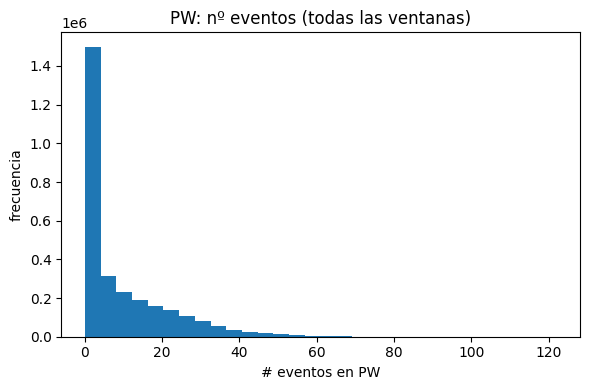

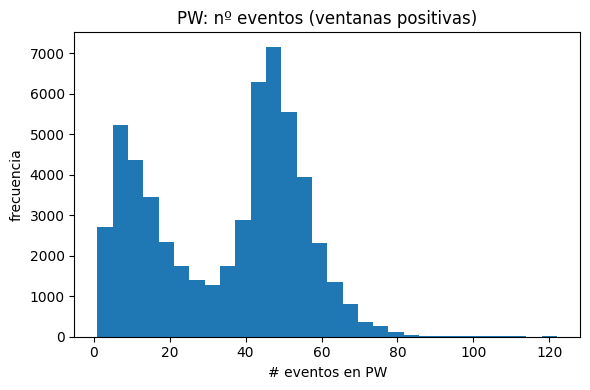

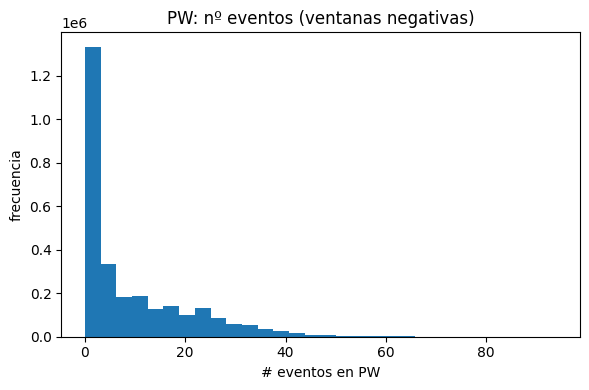

[OK] Figuras guardadas en: /Users/juancarlosduenaslopez/Documents/mlops/mlops4ofp/executions/04_targetengineering/v403/figures


In [16]:
# ---------------------------------------------
# Histogramas de eventos en ventanas de predicción (PW)
# ---------------------------------------------
import matplotlib.pyplot as plt

figures_dir = variant_root / "figures"
figures_dir.mkdir(parents=True, exist_ok=True)

pw_len_all = df["PW_events"].apply(len)
pw_len_pos = df.loc[df["label"] == 1, "PW_events"].apply(len)
pw_len_neg = df.loc[df["label"] == 0, "PW_events"].apply(len)

plt.figure(figsize=(6, 4))
plt.hist(pw_len_all, bins=30)
plt.title("PW: nº eventos (todas las ventanas)")
plt.xlabel("# eventos en PW")
plt.ylabel("frecuencia")
plt.tight_layout()
plt.savefig(figures_dir / "pw_events_all.png", dpi=150)
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(pw_len_pos, bins=30)
plt.title("PW: nº eventos (ventanas positivas)")
plt.xlabel("# eventos en PW")
plt.ylabel("frecuencia")
plt.tight_layout()
plt.savefig(figures_dir / "pw_events_pos.png", dpi=150)
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(pw_len_neg, bins=30)
plt.title("PW: nº eventos (ventanas negativas)")
plt.xlabel("# eventos en PW")
plt.ylabel("frecuencia")
plt.tight_layout()
plt.savefig(figures_dir / "pw_events_neg.png", dpi=150)
plt.show()

print(f"[OK] Figuras guardadas en: {figures_dir}")

In [17]:
# ---------------------------------------------
# Reporte HTML (conteos + enlaces a figuras)
# ---------------------------------------------
outputs = build_phase_outputs(variant_root, PHASE)
report_path = outputs["report"]

pos_pct = (labels_1 / total_windows * 100) if total_windows else 0.0
neg_pct = (labels_0 / total_windows * 100) if total_windows else 0.0

html = f"""<!DOCTYPE html>
<html lang=\"es\">
<head>
  <meta charset=\"utf-8\" />
  <title>Reporte F04 - {VARIANT}</title>
  <style>
    body {{ font-family: Arial, sans-serif; margin: 24px; }}
    .kpi {{ margin: 6px 0; }}
    ul {{ line-height: 1.6; }}
  </style>
</head>
<body>
  <h1>Fase 04 — Target Engineering</h1>
  <p><strong>Variante:</strong> {VARIANT}</p>
  <div class=\"kpi\">Ventanas (entrada F03): {total_windows}</div>
  <div class=\"kpi\">Etiquetas 1: {labels_1} ({pos_pct:.2f}%)</div>
  <div class=\"kpi\">Etiquetas 0: {labels_0} ({neg_pct:.2f}%)</div>
  <h2>Figuras</h2>
  <ul>
    <li><a href=\"figures/pw_events_all.png\">Histograma PW (todas)</a></li>
    <li><a href=\"figures/pw_events_pos.png\">Histograma PW (positivas)</a></li>
    <li><a href=\"figures/pw_events_neg.png\">Histograma PW (negativas)</a></li>
  </ul>
</body>
</html>"""

report_path.write_text(html, encoding="utf-8")
print(f"[OK] Reporte HTML guardado: {report_path}")

[OK] Reporte HTML guardado: /Users/juancarlosduenaslopez/Documents/mlops/mlops4ofp/executions/04_targetengineering/v403/04_targetengineering_report.html


In [18]:
# ---------------------------------------------
# Guardar dataset F04
# ---------------------------------------------

outputs = build_phase_outputs(variant_root, PHASE)

schema = pa.schema([
    ("OW_events", pa.list_(pa.int32())),
    ("label", pa.int8()),
])

table_out = pa.Table.from_pandas(df_out, schema=schema, preserve_index=False)
pq.write_table(table_out, outputs["dataset"])

print(f"[OK] Dataset guardado: {outputs['dataset']}")


[OK] Dataset guardado: /Users/juancarlosduenaslopez/Documents/mlops/mlops4ofp/executions/04_targetengineering/v403/04_targetengineering_dataset.parquet


In [19]:
# ---------------------------------------------
# Guardar metadata y params efectivos
# ---------------------------------------------

pm.save_generated_params(params)
pm.save_metadata(stats)

write_metadata(
    stage=PHASE,
    variant=VARIANT,
    parent_variant=parent_variant_f03,
    inputs=[str(input_dataset_path), str(event_catalog_path)],
    outputs=[str(outputs["dataset"])],
    params=params,
    metadata_path=outputs["metadata"],
)

print("[OK] Metadata y params guardados")

summary_path = variant_root / f"{PHASE}_summary.json"
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)

print(f"[OK] Summary guardado: {summary_path}")



[OK] Metadata y params guardados
[OK] Summary guardado: /Users/juancarlosduenaslopez/Documents/mlops/mlops4ofp/executions/04_targetengineering/v403/04_targetengineering_summary.json


In [20]:
print("F04 completed")
print("\n--- Prediction Summary ---")
print(f"Variant: {VARIANT}")
print(f"Prediction name: {prediction_name}")
print(f"Objective definition: {params['prediction_objective']}")
print(f"Labeled dataset path: {outputs['dataset']}")

F04 completed

--- Prediction Summary ---
Variant: v403
Prediction name: GE_Active_Power_any-to-80_100
Objective definition: {'operator': 'OR', 'events': ['GE_Active_Power_0_40-to-80_100', 'GE_Active_Power_40_60-to-80_100', 'GE_Active_Power_60_80-to-80_100']}
Labeled dataset path: /Users/juancarlosduenaslopez/Documents/mlops/mlops4ofp/executions/04_targetengineering/v403/04_targetengineering_dataset.parquet


## ✔ Fase 04 completada

Este dataset ya está listo para:
- análisis de balance
- definición de métricas
- entrenamiento de modelos (F05)

Cada variante representa **un objetivo de predicción explícito y trazable**.
